# Federal University of Santa Maria
### Technology Center
### Computer Engineering Course
- Author : Luis Felipe de Deus
- Created : 13 Jan 2021
- Update : 15 Jan 2021
- brief: IMPLEMENTATION OF A CONVOLUTION NEURAL NETWORK TO CLASSIFY CATS AND DOGS IMAGES


### IMPORT THE LIBS WHICH WE NEED

In [102]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dropout, Dense, Input, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split

### LOAD DATASET

In [59]:
# @brief:   This Function will get the path+name of typeFile param
# @param:   path is the path where the csv files are
# @return:  return a list of str path+filename
def findFiles(path,typeFile):
    paths = [os.path.join(path, name) for name in os.listdir(path)]
    files = [arq for arq in paths if os.path.isfile(arq)]
    csvs = [arq for arq in files if arq.lower().endswith(typeFile)]
    csvs.sort()
    #print("From path: Files founded: %d"%(len(csvs)))
    return csvs
#END

In [103]:
#LOAD THE TRAINING FILENAMES
path = 'train/'
train_imgs_files =  findFiles(path,'.jpg')
print("Size of Train set: ",len(train_imgs_files))

Size of Train set:  25000


In [107]:
# NOW SPLIT ONE PART FOR ACTUALLY TRAIN THE MODEL AND ONE PART FOR VALIDATION (80# / 20%)
train_imgs_files, valid_imgs_files = train_test_split(train_imgs_files, test_size=0.2, random_state=42)
print("Size of Train set: ",len(train_imgs_files))
print("Size of Valid set: ",len(valid_imgs_files))

Size of Train set:  20000
Size of Valid set:  5000


In [108]:
#LOAD THE TEST FILENAMES
path = 'test1/'
test_imgs_files =  findFiles(path,'.jpg')
print('Size of Test set: ',len(test_imgs_files))

Size of Test set:  12500


In [109]:
#NOW CREATE THE TRAINING DATAFRAME WITH FILENAMES AND LABELS
train_imgs = []

for i in range(len(train_imgs_files)):
    name = str(train_imgs_files[i]).split('/')[1]
    if('dog' in name):
        train_imgs.append([name,'dog'])
    else:
        train_imgs.append([name,'cat'])
        
train_df = pd.DataFrame(train_imgs,columns=['filename','class'])

In [110]:
train_df.head()

,filename,class
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat


In [111]:
#CHECK THE DATASET DISTRIBUTION
train_df['class'].value_counts()

dog    10015
cat     9985
Name: class, dtype: int64

In [112]:
#CREATE THE VALIDATION DATAFRAME WITH FILENAMES AND LABELS
valid_imgs = []

for i in range(len(valid_imgs_files)):
    name = str(valid_imgs_files[i]).split('/')[1]
    if('dog' in name):
        valid_imgs.append([name,'dog'])
    else:
        valid_imgs.append([name,'cat'])
        
valid_df = pd.DataFrame(valid_imgs,columns=['filename','class'])

In [113]:
valid_df.head()

,filename,class
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog


In [114]:
#CHECK THE DATASET DISTRIBUTION
valid_df['class'].value_counts()

cat    2515
dog    2485
Name: class, dtype: int64

In [115]:
#CREATE THE TEST DATAFRAME WITH FILENAMES AND LABELS AS -1 ( WE DON'T KNOW)
test_imgs = []
for i in range(len(test_imgs_files)):
    name = str(test_imgs_files[i]).split('/')[1]
    test_imgs.append([name,-1])
        
test_df = pd.DataFrame(test_imgs,columns=['filename','class'])

In [116]:
test_df.head()

,filename,class
0,1.jpg,-1
1,10.jpg,-1
2,100.jpg,-1
3,1000.jpg,-1
4,10000.jpg,-1


### IMAGE PREPROCESSING

In [73]:
#CREATE AN OBJECT OF IMAGE GENERATOR - NORMALIZE THE IMAGES WITH 255
generator = ImageDataGenerator(rescale = 1/255.0)

In [74]:
#GENERATORS
#WE HAVE TO PASS THE TRAIN DF
#THE DIRECTORY WHERE THE IMAGES ARE
#X_COL WE ARE SAYING THAT THE X DATA ARE THE IMAGES
#Y_COL WE ARE SAYING WHERE ARE THE LABELS
#TARGET_SIZE (WE ARE GOING TO RESIZE ALL THE IMAGES TO 64X64)
#COLOR_MODE - WE WANT USE THE IMAGES AS RGB
#CLASS MODE AS BINARY SAYS THAT THE IMAGES EITHER CAN BE DOG OR CAT
#SHUFFLE THE DATASET SO WE ARE NOT CHEATING

In [117]:
#CREATE THE TRAIN GENERATOR
train_generator = generator.flow_from_dataframe(
            dataframe = train_df,
            directory='train',
            x_col="filename",
            y_col="class",
            weight_col=None,
            target_size=(64, 64),
            color_mode="rgb",
            classes=None,
            class_mode='binary',
            batch_size=32,
            shuffle=True,
            validate_filenames=True
)

Found 20000 validated image filenames belonging to 2 classes.


In [118]:
#CREATE THE VALID GENERATOR
valid_generator = generator.flow_from_dataframe(
            dataframe = valid_df,
            directory='train',
            x_col="filename",
            y_col="class",
            weight_col=None,
            target_size=(64, 64),
            color_mode="rgb",
            classes=None,
            class_mode='binary',
            batch_size=32,
            shuffle=True,
            validate_filenames=True
)

Found 5000 validated image filenames belonging to 2 classes.


In [119]:
#CREATE THE TEST GENERATOR
test_generator = generator.flow_from_dataframe(
            dataframe = test_df,
            directory='test1',
            x_col="filename",
            #y_col="class",
            weight_col=None,
            target_size=(64, 64),
            color_mode="rgb",
            classes=None,
            class_mode=None,
            batch_size=32,
            shuffle=False,
            validate_filenames=True
)

Found 12500 validated image filenames.


In [120]:
#JUST PRINT THE SHAPE OF ONE SAMPLE TO BE SURE OF
x_train, y_train = next(train_generator)
print(x_train.shape)
print(y_train.shape)

(32, 64, 64, 3)
(32,)


### NEURAL NETWORKS

In [121]:
#CREATE THE NEURAL NET MODEL - CONVOLUTIONAL NEURAL NETWORK
def build_model():
    model = Sequential()

    model.add(Conv2D(input_shape = (64, 64, 3), filters = 32, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2))) 

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu', kernel_initializer = 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'he_normal'))

    return model

model = build_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 32)        864       
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 32)        9216      
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)       

In [41]:
%%time
#COMPILE THE MODEL USING THE ADAM OPTIMIZER
#WE ARE LOOKING AT THE BINARY ACCURACY AND CROSSENTROPY

model.compile(loss = 'binary_crossentropy', optimizer = 'adagrad', metrics = ['binary_accuracy'])

#FIT THE MODEL FOR 100 EPOCHS, BATCH SIZE AS 32
history = model.fit(train_generator,
                        epochs = 50,
                        batch_size = 32,
                        validation_data=valid_generator,
                        steps_per_epoch = len(train_generator))

Epoch 1/50
625/625 [==============================] - 136s 217ms/step - loss: 0.6541 - binary_accuracy: 0.6387 - val_binary_accuracy: 0.6922 - val_loss: 0.5823
Epoch 2/50
625/625 [==============================] - 136s 218ms/step - loss: 0.5648 - binary_accuracy: 0.7040 - val_binary_accuracy: 0.7162 - val_loss: 0.5527
Epoch 3/50
625/625 [==============================] - 136s 218ms/step - loss: 0.5224 - binary_accuracy: 0.7393 - val_binary_accuracy: 0.7386 - val_loss: 0.5251
Epoch 4/50
625/625 [==============================] - 135s 216ms/step - loss: 0.4948 - binary_accuracy: 0.7620 - val_binary_accuracy: 0.7440 - val_loss: 0.5079
Epoch 5/50
625/625 [==============================] - 136s 218ms/step - loss: 0.4654 - binary_accuracy: 0.7783 - val_binary_accuracy: 0.7540 - val_loss: 0.4971
Epoch 6/50
625/625 [==============================] - 136s 217ms/step - loss: 0.4403 - binary_accuracy: 0.7944 - val_binary_accuracy: 0.7626 - val_loss: 0.4875
Epoch 7/50
625/625 [====================

### PLOT LEARNING CURVES

<IPython.core.display.Javascript object>


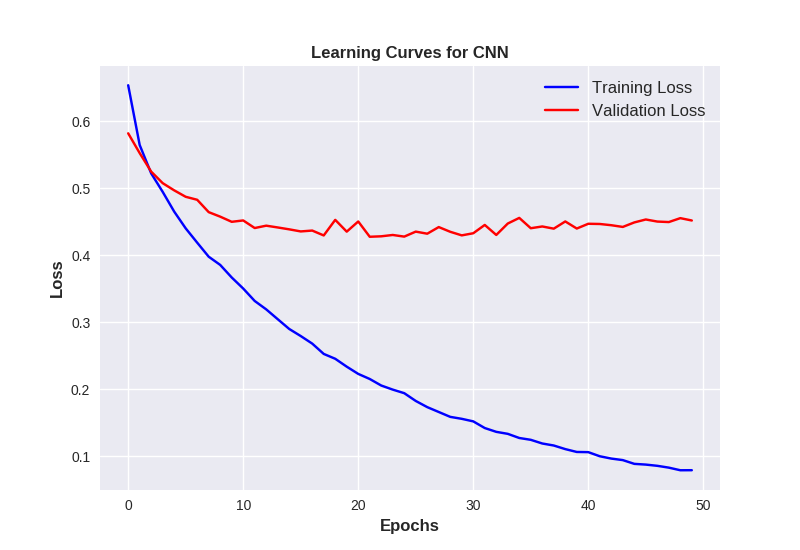

In [42]:
%matplotlib notebook
#Plot learning curve - loss
plt.style.use('seaborn')
plt.title("Learning Curves for CNN", fontsize = 'large',fontweight = 'bold')
plt.plot(history.history['loss'], color='blue',label='Training Loss')
plt.plot(history.history['val_loss'], color='red',label='Validation Loss')
plt.xlabel('Epochs',  fontsize = 'large',fontweight = 'bold')
plt.ylabel('Loss', fontsize = 'large',fontweight = 'bold')
plt.legend(fontsize = 'large')
plt.show()

<IPython.core.display.Javascript object>


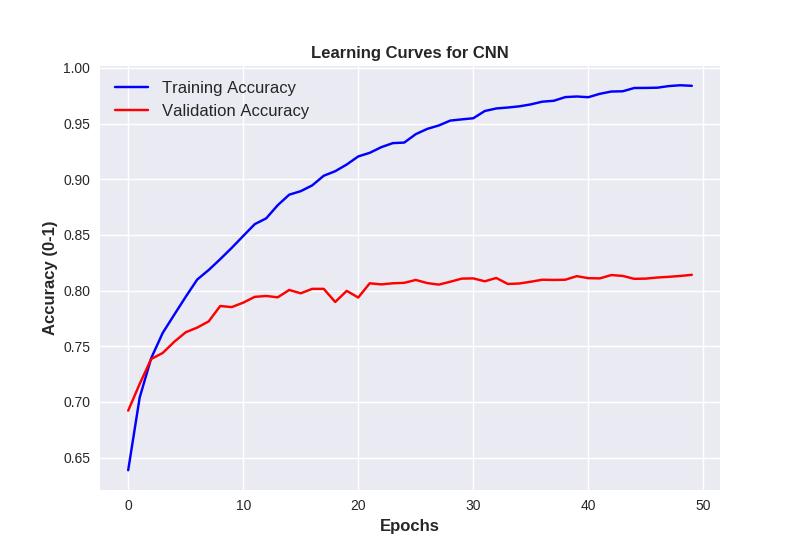

In [43]:
%matplotlib notebook
#Plot learning curve - loss
plt.style.use('seaborn')
plt.title("Learning Curves for CNN", fontsize = 'large',fontweight = 'bold')
plt.plot(history.history['binary_accuracy'], color='blue',label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], color='red',label='Validation Accuracy')
plt.xlabel('Epochs',  fontsize = 'large',fontweight = 'bold')
plt.ylabel('Accuracy (0-1)', fontsize = 'large',fontweight = 'bold')
plt.legend(fontsize = 'large')
plt.show()

### SAVE MODEL

In [44]:
MODEL = model

# serialize model to JSON
model_json = MODEL.to_json()
with open("CNN_50EPOCHS_cats_dogs_adagrad_v0.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
MODEL.save_weights("CNN_50EPOCHS_cats_dogs_adagrad_v0.h5")
print("Saved model to disk")
np.save('CNN_50EPOCHS_cats_dogs_adagrad_v0.npy',history.history)

Saved model to disk


### HOW TO LOAD THE MODEL FROM DISK

In [122]:
#Create names
filename_m = 'models/CNN_100EPOCS_cats_dogs_adamv2'
        
# load json
json_file = open(filename_m+'.json', 'r')
model_json = json_file.read()
json_file.close()
        
#Load NN
model = tf.keras.models.model_from_json(model_json)
# Load Weights into new model
model.load_weights(filename_m+'.h5')
print("Loaded Model from disk")

Loaded Model from disk


### MAKE PREDICTIONS OVER TEST SET

In [123]:
predictions = model.predict(test_generator, batch_size=32)

In [124]:
test_df['class'] = np.around(predictions,0)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['class'] = test_df['class'].replace(label_map)

test_df['class'] = test_df['class'].replace({ 'dog': 1, 'cat': 0 })

In [125]:
test_df

,filename,class
0,1.jpg,1
1,10.jpg,0
2,100.jpg,1
3,1000.jpg,1
4,10000.jpg,1
5,10001.jpg,0
6,10002.jpg,0
7,10003.jpg,1
8,10004.jpg,1
9,10005.jpg,0


### SHOW SOME OF THE PREDICTED IMAGES

      filename  class
5607  3795.jpg      1
5608  3796.jpg      1
5609  3797.jpg      1
5610  3798.jpg      0
5611  3799.jpg      1


<IPython.core.display.Javascript object>


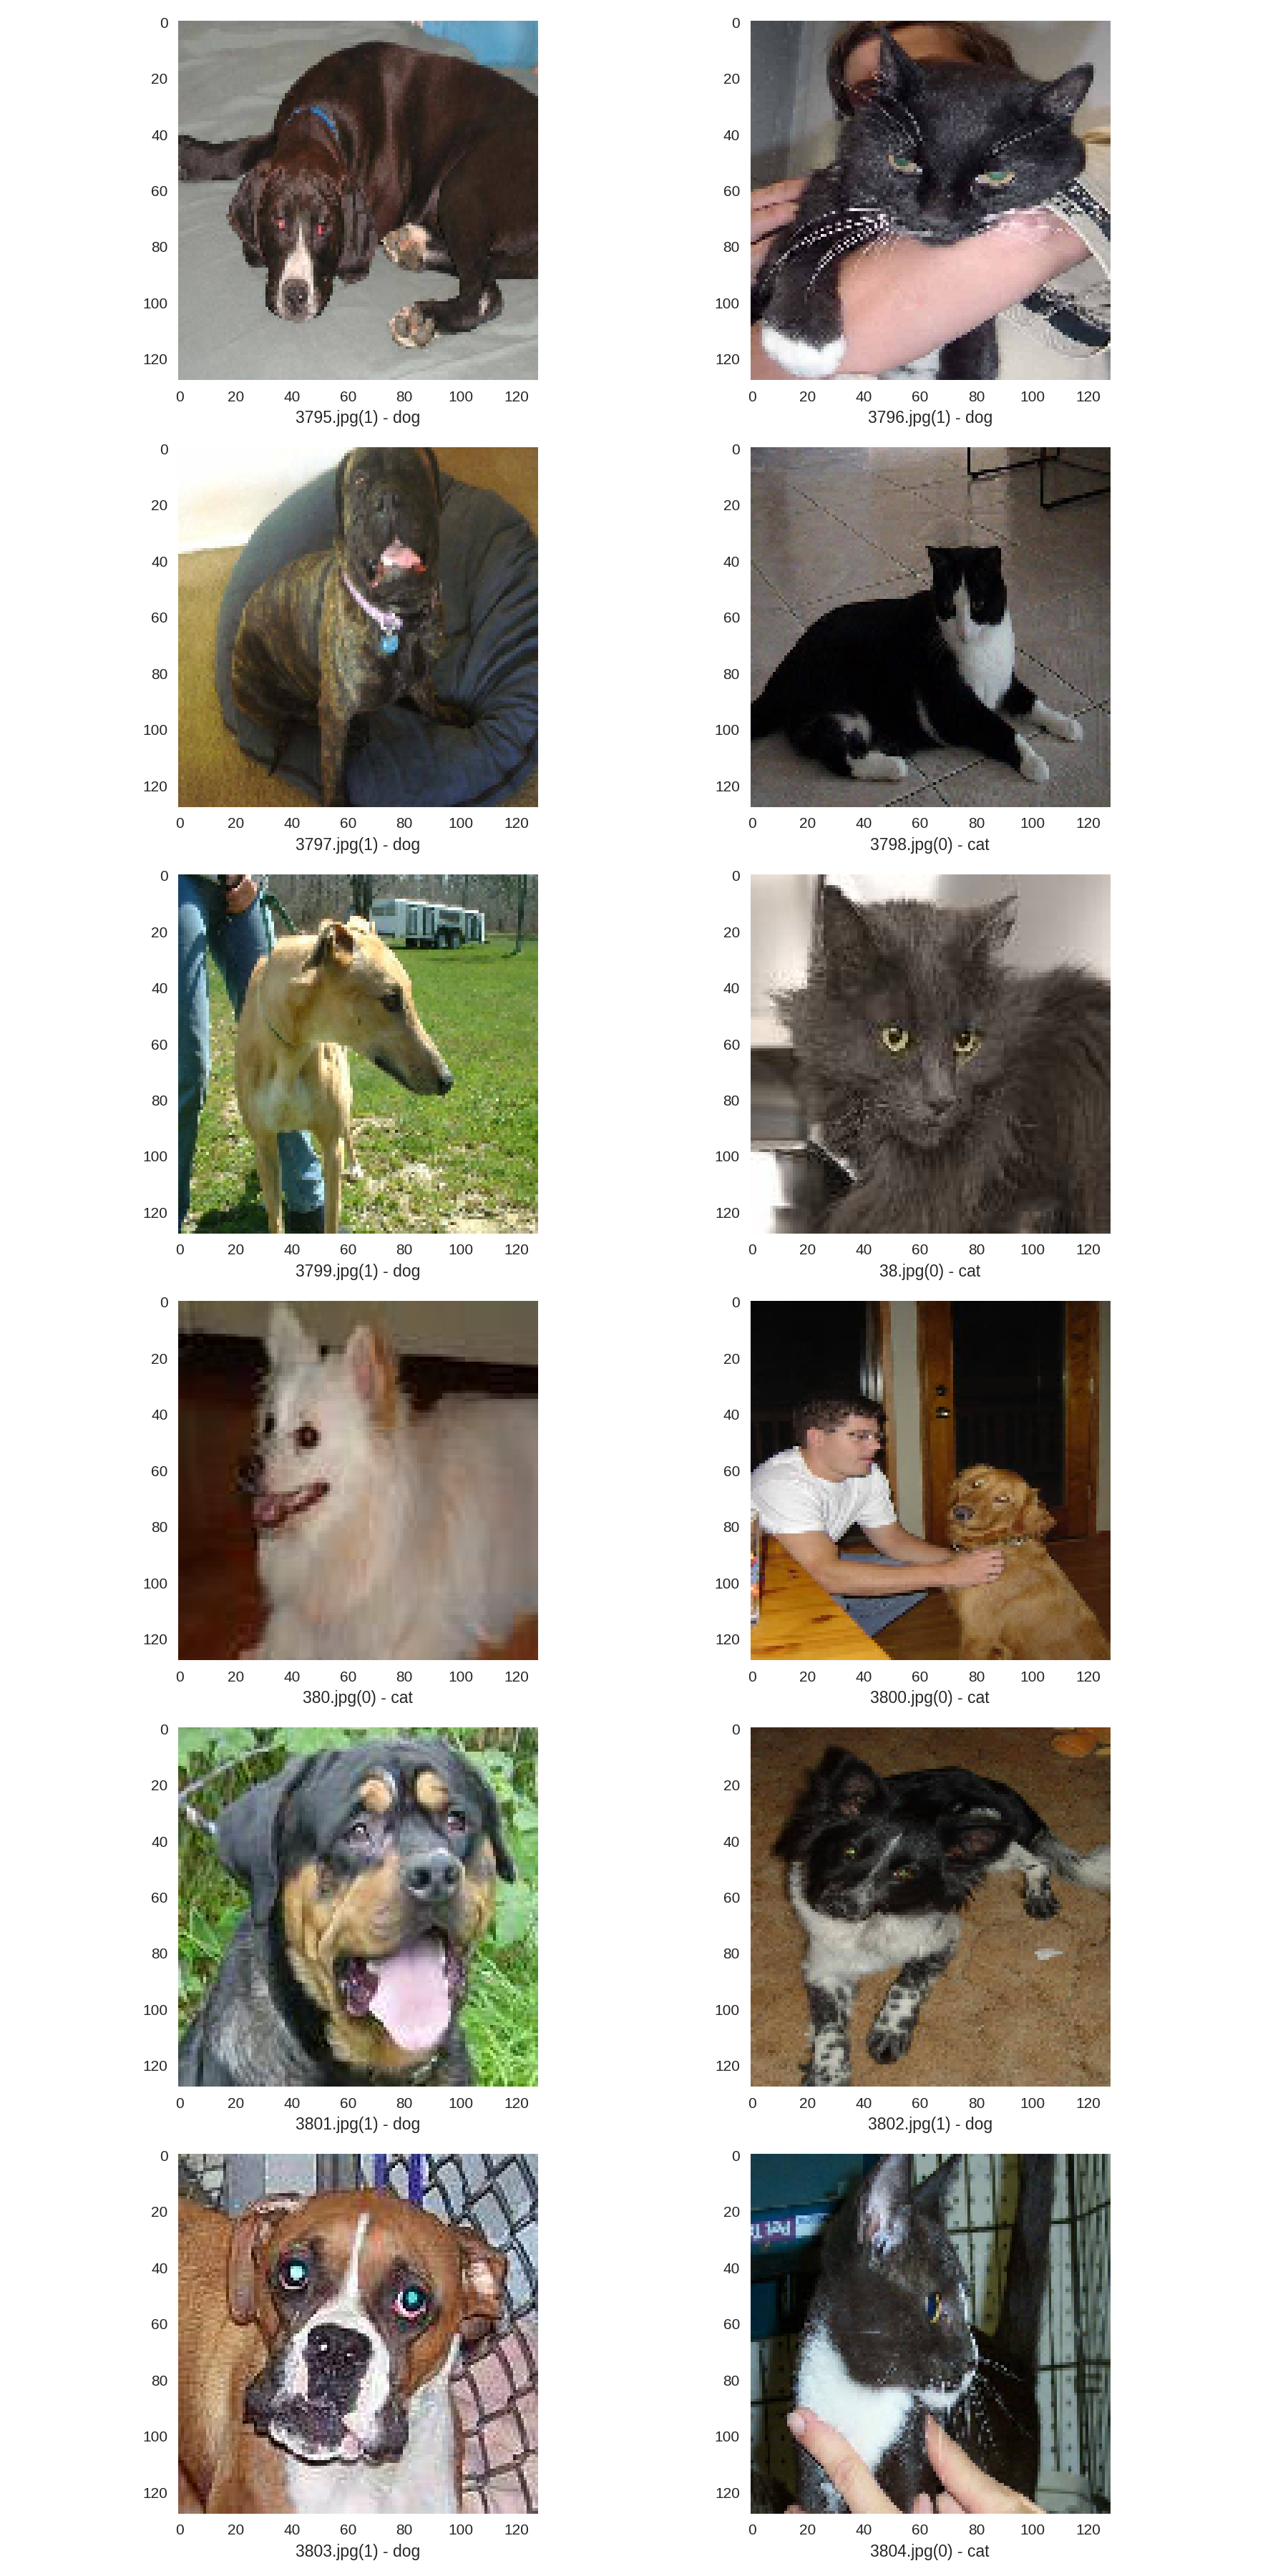

In [127]:
results={
    0:'cat',
    1:'dog'
}

#Create a random subsample
rand_numb = np.random.randint(0, test_df.shape[0], 1)[0]

#sample_test = test_df.head(18)
sample_test = test_df[rand_numb:rand_numb+12]
print(sample_test.head())

plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['class']
    img = load_img("test1/"+filename, target_size=(128,128))
    i = index - rand_numb
    plt.subplot(6, 2, i+1)
    plt.imshow(img)
    #if(category =):
    plt.xlabel(filename + '(' + "{}".format(category) + ') - '+results[category]  )
    plt.grid(False)
plt.tight_layout()
plt.show()

### TRYING TO PREDICT MY DOGS

In [128]:
my_animals = findFiles('custom/','.jpg')
my_animals

['custom/cat0.jpg',
 'custom/cat1.jpg',
 'custom/cat2.jpg',
 'custom/cat3.jpg',
 'custom/dog0.jpg',
 'custom/dog1.jpg',
 'custom/dog2.jpg',
 'custom/dog3.jpg',
 'custom/dog4.jpg',
 'custom/fat_dog.jpg',
 'custom/francoa.jpg',
 'custom/hanna0.jpg',
 'custom/hanna1.jpg',
 'custom/leci.jpg',
 'custom/random_cat.jpg',
 'custom/slinky.jpg',
 'custom/slinky1.jpg',
 'custom/tita.jpg']

[1] dog


<IPython.core.display.Javascript object>


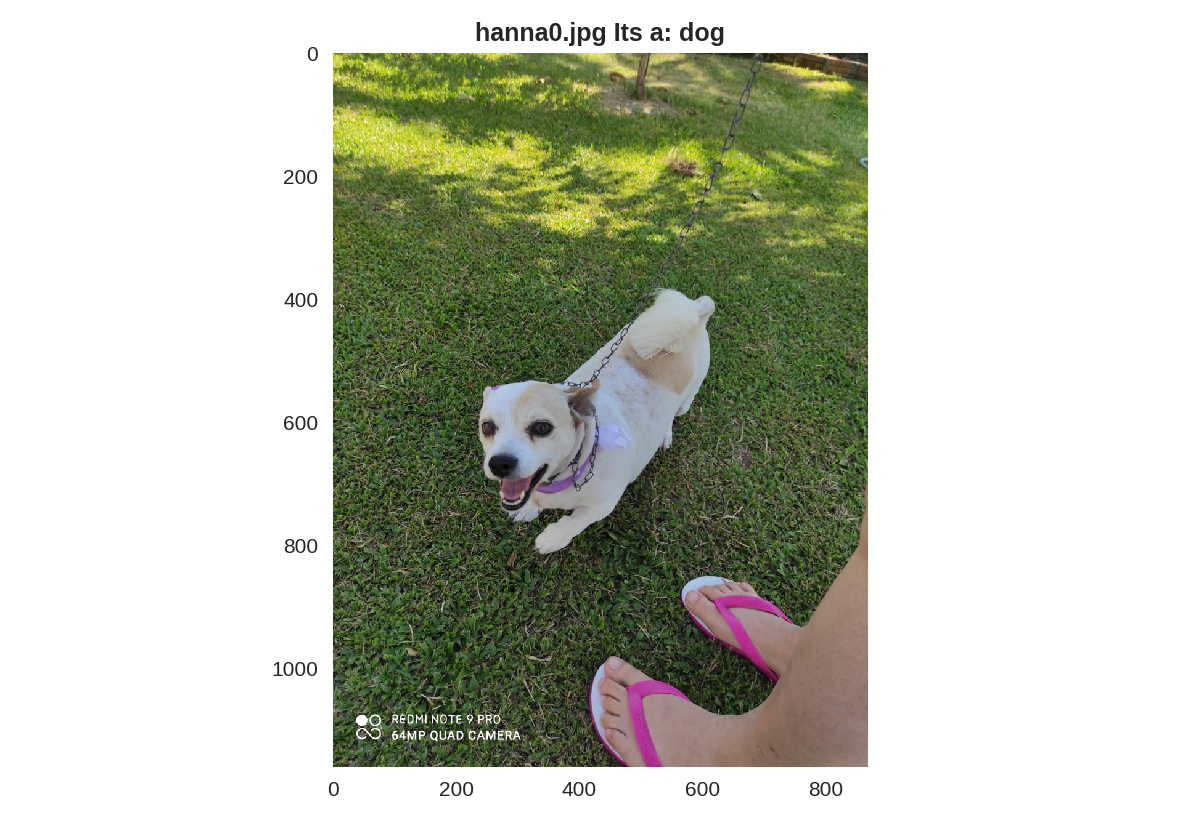

In [135]:
%matplotlib notebook
results={
    0:'cat',
    1:'dog'
}
Image_Size = (64,64)
from PIL import Image

#Image name
fn = my_animals[-7]

#Image preprocessing
#im0=Image.open("custom/"+fn+".jpg")
im0=Image.open(fn)
im=im0.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255

#Make the prediction
pred=model.predict_classes([im])[0]
print(pred,results[pred[0]])

#Now show to us the image along with the prediction
plt.imshow(im0)
plt.title(fn.split('/')[-1]+" Its a: "+results[pred[0]], fontsize = 'large',fontweight = 'bold')
plt.grid(False)
plt.tight_layout()
plt.show()